### Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert

import os, os.path
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import multivariate_normal
import scipy as sp
from scipy import interpolate
from sklearn.neighbors import KernelDensity

import sys
sys.path.append("..")
from ERTsim import PHert

import pickle as pkl


import pandas as pd

In [2]:
dip = 126
H = 87
xpos = 384
rhob = 121
rhof = 37

trueparams = [dip, H, xpos, rhof, rhob]
suffix0 = '_noanomaly'
suffix1 = '_withanomaly'

mfile = 'models_shallowlayer.pkl'
MCfolder = '../data/shallowlayer/' 
# mfile = 'models_NormNoise.pkl'
# MCfolder = '../data/MC3/' 

### Define Functions for Later

In [3]:
def sample_data(N,dmean,dstd):
    D_N = np.zeros((N,dmean.shape[0]))
    for i in range(dmean.shape[0]):
        D_N[:,i] = np.random.normal(dmean[i], dstd[i], N)
    return D_N
        
def train_reg(dtrain, vtrain):
    return RandomForestRegressor().fit(dtrain, vtrain)

def sample_posterior(reg, dtest, vtest_true, D_N, W):
    vtest_pred = reg.predict(dtest)
    vmeas_pred = reg.predict(D_N)
    
    postsamples = np.zeros(D_N.shape[0])
    for i in range(D_N.shape[0]):
        INDS = np.where(np.logical_and(vtest_pred>=vmeas_pred[i]-W, vtest_pred<=vmeas_pred[i]+W))
        csamples = vtest_true[INDS]
        sample_ind = np.random.choice(csamples.shape[0], 1)        
        
        postsamples[i] = csamples[sample_ind]
    return postsamples
    

# Import the Measured ERT Data

In [4]:
sfile = '../data/PH-2018-srv.txt'
efile = '../data/PH-2018-eloc.txt'
srv = pd.read_csv(sfile,sep='\t',header=None)
elec = pd.read_csv(efile,sep='\t',header=None)

M = (elec.values[srv.values[:,2][:].astype(int)-1,1]+elec.values[srv.values[:,4][:].astype(int)-1,1])/2
C = (elec.values[srv.values[:,1][:].astype(int)-1,3]+elec.values[srv.values[:,3][:].astype(int)-1,3])/2 - (elec.values[srv.values[:,4][:].astype(int)-1,1]-elec.values[srv.values[:,2][:].astype(int)-1,1])/2



hetero_data=pg.physics.ert.load('ert'+suffix0+'.data')
measured0 = np.array([hetero_data('r')[i] for i in range(hetero_data('r').size())])

hetero_data=pg.physics.ert.load('ert'+suffix1+'.data')
measured1 = np.array([hetero_data('r')[i] for i in range(hetero_data('r').size())])

# Import the Monte Carlo Data

In [5]:
rows = 11 # Number of header rows

In [6]:
pfile = MCfolder + 'params.dat' #Parameter file

files = [name for name in os.listdir(MCfolder) if (os.path.isfile(MCfolder+name) and (name != "params.dat"))]
Nreal = len(files)

In [7]:
DNew = np.zeros((Nreal,15371))
inds = np.zeros(Nreal,dtype=int)
i = 0
for f in files:
    data = ert.ERTManager(MCfolder+f).data
    R = np.array([data('r')[i] for i in range(data('r').size())])
    DNew[i,:] = R
    f2 = f.split('_')[1]
    inds[i] = np.int(f2.split('.')[0])
    i = i+1


In [8]:
fullinput = pd.read_csv(pfile,skiprows=rows) #Dataframe version
inputs = fullinput.values[inds,:] #Matrix version
fullinput

,dip,H,xpos,rho_fault,rho_back
0,101.833891,115.800812,412.011373,29.642176,49.316446
1,125.126511,174.696599,484.424341,27.897438,229.946475
2,109.386873,53.786238,456.523421,42.869513,72.535312
3,101.283646,126.145778,460.279214,26.864429,58.730871
4,84.311672,56.621057,432.695884,25.424708,68.864551
...,...,...,...,...,...
1995,135.779417,144.507231,406.534273,24.860789,84.199023
1996,125.967736,96.671548,375.001311,31.356123,81.066461
1997,92.215093,145.760068,370.331503,30.884901,85.394349
1998,115.140965,47.364446,405.448911,26.081312,205.104687


# Add Noise to the Monte Carlo ERT Data

In [9]:
itrain = np.int(np.round(.5 * inputs.shape[0]))

# DNew = np.zeros(D.shape)
for i in range(DNew.shape[0]):
    DNew[i,:] = sample_data(1,DNew[i,:],srv.values[:,6])
    
# DNoise = D+Noise

dmean = np.mean(DNew[:itrain,:],axis=0)
dstd = np.std(DNew[:itrain,:],axis=0)
DNew = (DNew-dmean)/dstd #Normalizing measurements

# Sample Measurement Realizations

In [10]:
N = 10000 #Number of measurement realizations

pca = PCA()
pca.fit(DNew[:itrain,:])

D_N_filt = (sample_data(N, srv.values[:,5], srv.values[:,6])-dmean)/dstd #Normalizing data samples
D_N_filt0 = (sample_data(N, measured0, srv.values[:,6])-dmean)/dstd #Normalizing data samples
D_N_filt1 = (sample_data(N, measured1, srv.values[:,6])-dmean)/dstd #Normalizing data samples

# S_real_noise = 
D_N_filt = pca.inverse_transform(pca.transform(D_N_filt))

# S_real_noise0 = pca.transform(D_N0)
D_N_filt0 = pca.inverse_transform(pca.transform(D_N_filt0))

# S_real_noise1 = pca.transform(D_N1)
D_N_filt1 = pca.inverse_transform(pca.transform(D_N_filt1))

# Train Random Forest Regression Inverse Models

In [11]:
try:
    models = pkl.load(open( mfile, "rb" ))
except:    
    models = [None]*5
    for i in range(5):
        print('Training '+str(i+1)+' of 5')
        models[i] = train_reg(DNew[:itrain,:],inputs[:itrain,i])

    pkl.dump(models,open(mfile, "wb" ))

# Sample the Posterior for Each Model Parameter

In [12]:
Ws = (2.5, 5, 5, 5, 5) #Error tolerances
postsamples = [None]*5
postsamples0 = [None]*5
postsamples1 = [None]*5
for i in range(5):
    print('Sampling '+str(i+1)+' of 5')
    postsamples[i] = sample_posterior(models[i], DNew[itrain+1:,:], inputs[itrain+1:,i], D_N_filt, Ws[i])
    postsamples0[i] = sample_posterior(models[i], DNew[itrain+1:,:], inputs[itrain+1:,i], D_N_filt0, Ws[i])
    postsamples1[i] = sample_posterior(models[i], DNew[itrain+1:,:], inputs[itrain+1:,i], D_N_filt1, Ws[i])


Sampling 1 of 5
Sampling 2 of 5
Sampling 3 of 5
Sampling 4 of 5
Sampling 5 of 5


# Train/Test Prediction Plots

/home/ammilten/anaconda3/envs/pg/lib/python3.7/site-packages/ipykernel_launcher.py:42: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ammilten/anaconda3/envs/pg/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


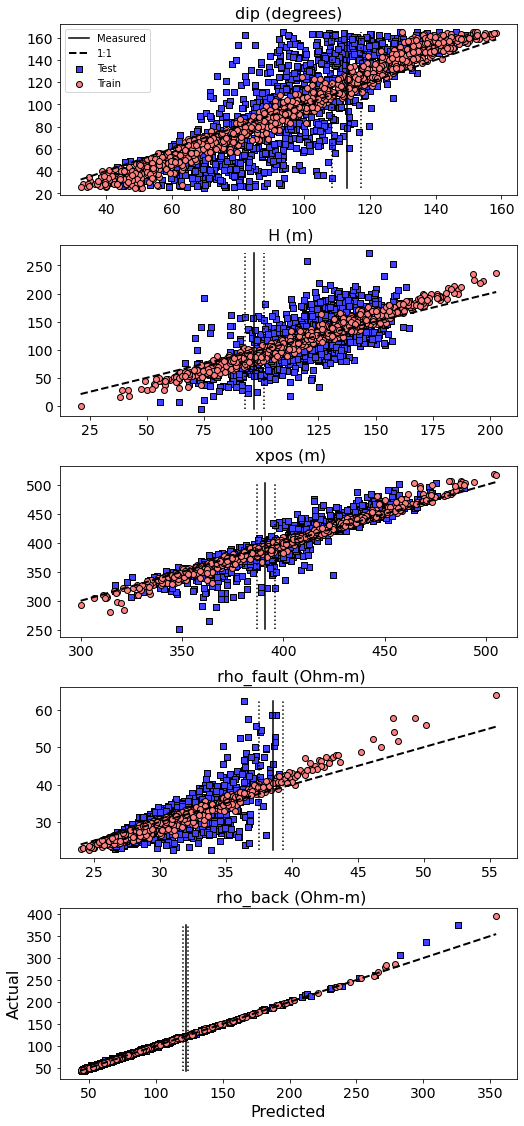

In [28]:
units = ('degrees','m','m','Ohm-m','Ohm-m')
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(6*1.23,15*1.05))
for i in range(5):
    vtrain = inputs[:itrain,i]
    vtest = inputs[itrain+1:,i]
    
    vpred_meas = models[i].predict(D_N_filt)
    vpred_meas0 = models[i].predict(D_N_filt0)
    vpred_meas1 = models[i].predict(D_N_filt1)
    
    vpred_test = models[i].predict(DNew[itrain+1:,:])
    vpred_train = models[i].predict(DNew[:itrain,:])
    
    vmin = np.min((np.min(vpred_train), np.min(vpred_test)))
    vmax = np.max((np.max(vpred_train), np.max(vpred_test)))
    
    plt.subplot(511+i)
    
    plt.scatter(vpred_test,inputs[itrain+1:,i],color=(.25,.25,1),marker='s',edgecolor='k',label='Test')
    plt.scatter(vpred_train,inputs[:itrain,i],color=(1,.5,.5),marker='o',edgecolor='k',label='Train')
    
    plt.plot([np.percentile(vpred_meas,50), np.percentile(vpred_meas,50)], [np.min(vtest), np.max(vtest)],'-k',label='Measured')
    plt.plot([np.percentile(vpred_meas,2.5), np.percentile(vpred_meas,2.5)], [np.min(vtest), np.max(vtest)],':k')
    plt.plot([np.percentile(vpred_meas,97.5), np.percentile(vpred_meas,97.5)], [np.min(vtest), np.max(vtest)],':k')

#     plt.plot([np.percentile(vpred_meas0,50), np.percentile(vpred_meas0,50)], [np.min(vtest), np.max(vtest)],'-r',label='Anomaly')
#     plt.plot([np.percentile(vpred_meas0,2.5), np.percentile(vpred_meas0,2.5)], [np.min(vtest), np.max(vtest)],':r')
#     plt.plot([np.percentile(vpred_meas0,97.5), np.percentile(vpred_meas0,97.5)], [np.min(vtest), np.max(vtest)],':r')
    
#     plt.plot([np.percentile(vpred_meas1,50), np.percentile(vpred_meas1,50)], [np.min(vtest), np.max(vtest)],'-b',label='No Anomaly')
#     plt.plot([np.percentile(vpred_meas1,2.5), np.percentile(vpred_meas1,2.5)], [np.min(vtest), np.max(vtest)],':b')
#     plt.plot([np.percentile(vpred_meas1,97.5), np.percentile(vpred_meas1,97.5)], [np.min(vtest), np.max(vtest)],':b')

    plt.plot([vmin,vmax], [vmin,vmax],'--k',linewidth=2,label='1:1')
#     plt.xlabel('Predicted '+ fullinput.columns[i])
#     plt.ylabel('Actual '+ fullinput.columns[i])
    plt.title(fullinput.columns[i] + ' ('+units[i]+')',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    
plt.subplot(511)
plt.legend()

plt.subplot(515)
plt.xlabel('Predicted',fontsize=16)
plt.ylabel('Actual',fontsize=16)

fig.tight_layout()

# Prior & Posterior Distributions

In [14]:
import scipy.stats as st

dip = [25, 165] #uniform
H = [120, 40] #normal
xpos = [400,40] #normal
rho_fault = [20, 10, .45] #lognormal
rho_back = [40, 30, .8] #lognormal

dipd = st.uniform(loc=dip[0], scale=dip[1]-dip[0])
Hd = st.norm(loc=H[0], scale=H[1])
xposd = st.norm(loc=xpos[0], scale=xpos[1])
rho_faultd = st.lognorm(rho_fault[2],loc=rho_fault[0], scale=rho_fault[1])
rho_backd = st.lognorm(rho_back[2],loc=rho_back[0], scale=rho_back[1])

xs = [None]*5
pds = [None]*5

xs[0] = np.linspace(dipd.ppf(0.001)-10, dipd.ppf(0.999)+10, 1000)
pds[0] = dipd.pdf(xs[0])

xs[1] = np.linspace(Hd.ppf(0.001), Hd.ppf(0.999), 1000)
pds[1] = Hd.pdf(xs[1])
    
xs[2] = np.linspace(xposd.ppf(0.001), xposd.ppf(0.999), 1000)
pds[2] = xposd.pdf(xs[2])
    
xs[3] = np.linspace(rho_faultd.ppf(0.001), rho_faultd.ppf(0.999), 1000)
pds[3] = rho_faultd.pdf(xs[3])
    
xs[4] = np.linspace(rho_backd.ppf(0.001), rho_backd.ppf(0.96), 1000)
pds[4] = rho_backd.pdf(xs[4])


/home/ammilten/anaconda3/envs/pg/lib/python3.7/site-packages/ipykernel_launcher.py:37: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/ammilten/anaconda3/envs/pg/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


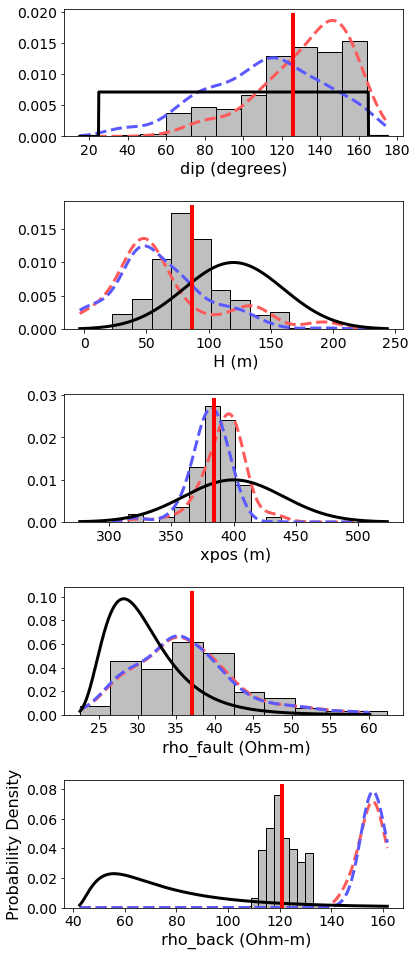

In [15]:
bw = [10,15,8,2,4]
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=((6*1.23)*.8,(15*1.05)*.85))
for i in range(5):
    plt.subplot(511+i)
    
    kde = KernelDensity(kernel="gaussian",bandwidth=bw[i])
    kde.fit(postsamples[i][:,None])
    logprob = kde.score_samples(xs[i][:,None])
    post_prob = np.exp(logprob)
#     plt.plot(xs[i],post_prob,':',color=(.25,.25,.25),linewidth=3,label='Measured Posterior')
    plt.hist(postsamples[i],density=True,facecolor=(.75,.75,.75),edgecolor='k',label='Measured Posterior')

    
    kde0 = KernelDensity(kernel="gaussian",bandwidth=bw[i])
    kde0.fit(postsamples0[i][:,None])
    logprob0 = kde0.score_samples(xs[i][:,None])
    post_prob0 = np.exp(logprob0)
    plt.plot(xs[i],post_prob0,'--',color=(1,.35,.35),linewidth=3,label='Synthetic Posterior (No Anomaly)')
    
    kde1 = KernelDensity(kernel="gaussian",bandwidth=bw[i])
    kde1.fit(postsamples1[i][:,None])
    logprob1 = kde1.score_samples(xs[i][:,None])
    post_prob1 = np.exp(logprob1)
    plt.plot(xs[i],post_prob1,'--',color=(.35,.35,1),linewidth=3,label='Synthetic Posterior (Anomaly)')
    
#     plt.hist(postsamples0[i],density=True,facecolor=(1,.25,.25),edgecolor='k',label='Posterior (No Anomaly)')
#     plt.hist(postsamples1[i],density=True,facecolor=(.5,.5,.5,.5),edgecolor='k',linewidth=1,label='Posterior (Anomaly)')

    plt.plot(xs[i],pds[i],'-',color='k',linewidth=3,label='Prior')
    yl = plt.ylim()
    plt.plot([trueparams[i], trueparams[i]], yl, color='r', linewidth=4,  label='Measured Posterior Mean')
    plt.xlabel(fullinput.columns[i] + ' ('+units[i]+')',fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    
plt.subplot(511)
# plt.legend()

plt.subplot(515)
plt.ylabel('Probability Density',fontsize=16)
    
fig.tight_layout()

In [16]:
print('-- Posterior Statistics (mean, std) --')
print('Dip:   '+str(np.round(np.mean(postsamples[0]),2))+', '+str(np.round(np.std(postsamples[0]),2)))
print('H:     '+str(np.round(np.mean(postsamples[1]),2))+', '+str(np.round(np.std(postsamples[1]),2)))
print('Xpos:  '+str(np.round(np.mean(postsamples[2]),2))+', '+str(np.round(np.std(postsamples[2]),2)))
print('rho_f: '+str(np.round(np.mean(postsamples[3]),2))+', '+str(np.round(np.std(postsamples[3]),2)))
print('rho_b: '+str(np.round(np.mean(postsamples[4]),2))+', '+str(np.round(np.std(postsamples[4]),2)))


-- Posterior Statistics (mean, std) --
Dip:   125.58, 27.16
H:     86.15, 28.73
Xpos:  384.76, 17.19
rho_f: 37.02, 7.22
rho_b: 121.05, 5.68


# Variable Importances

/home/ammilten/anaconda3/envs/pg/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/ammilten/anaconda3/envs/pg/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  del sys.path[0]


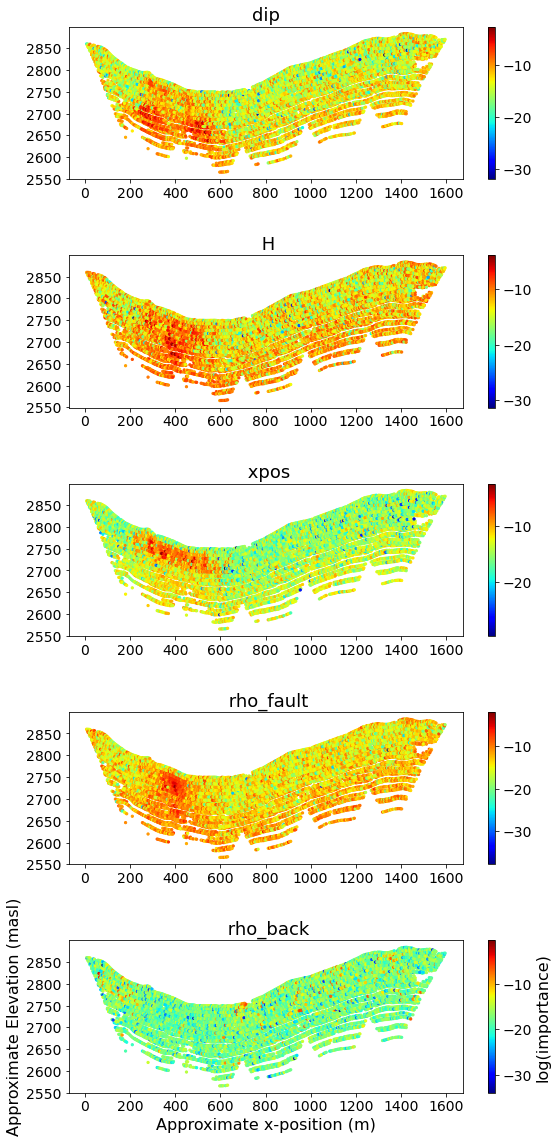

In [17]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(8,16))
for i in range(5):
    plt.subplot(511+i)
    
    imp = models[i].feature_importances_
    plt.scatter(M,C,5,c=np.log(imp), cmap='jet')
    plt.title(fullinput.columns[i],fontsize=18)
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=14)     
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

plt.subplot(515)
cb.set_label(label='log(importance)',fontsize=16)
plt.xlabel('Approximate x-position (m)',fontsize=16)
plt.ylabel('Approximate Elevation (masl)',fontsize=16)
plt.tight_layout()

# Relating Posterior Distributions to Hypotheses

In [18]:
H_bedplanes_d = st.norm(loc=160, scale=3)

H_thrust_d_1 = st.norm(loc=180-35,scale=5)
H_thrust_d_2 = st.norm(loc=35,scale=5)

H_fault_d_1 = st.norm(loc=180-65,scale=5)
H_fault_d_2 = st.norm(loc=65,scale=5)

H_sackung_d = st.norm(loc=85,scale=5)


In [19]:
# H_priors = [None]*4
# H_priors[0] = H_bedplanes_d.pdf(xs[0])
# H_priors[1] = .5*H_thrust_d_1.pdf(xs[0])+.5*H_thrust_d_2.pdf(xs[0])
# H_priors[2] = .5*H_fault_d_1.pdf(xs[0])+.5*H_fault_d_2.pdf(xs[0])
# H_priors[3] = H_sackung_d.pdf(xs[0])
# H_labels = ["Bedding Plane", "Thrust Fault", "Normal/Reverse Fault", "Sackung Fissure"]

H_priors = [None]*6
H_priors[5] = H_bedplanes_d.pdf(xs[0])
H_priors[4] = H_thrust_d_1.pdf(xs[0])
H_priors[0] = H_thrust_d_2.pdf(xs[0])
H_priors[3] = H_fault_d_1.pdf(xs[0])
H_priors[1] = H_fault_d_2.pdf(xs[0])
H_priors[2] = H_sackung_d.pdf(xs[0])
# H_labels = ["Bedding Plane", "Thrust (SW)", "Thrust (NE)", "Normal/Reverse (SW)", "Normal/Reverse (NE)", "Sackung Fissure"]
H_labels = ["Thrust (NE)", "Normal/Reverse (NE)", "Sackung Fissure", "Normal/Reverse (SW)", "Thrust (SW)", "Bedding Plane"]
styles = ['--b','--g','--c','-g','-b','-']


# priors = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]
# priors = [0.9/5, 0.9/5, 0.1, 0.9/5, 0.9/5, 0.9/5]
priors = [1/6, 0.2, 0.1, 0.2, 1/6, 1/6]


In [20]:
kde = KernelDensity(kernel="gaussian",bandwidth=8)
kde.fit(postsamples[0][:,None])

logprob = kde.score_samples(xs[0][:,None])
post_dip_prob = np.exp(logprob)

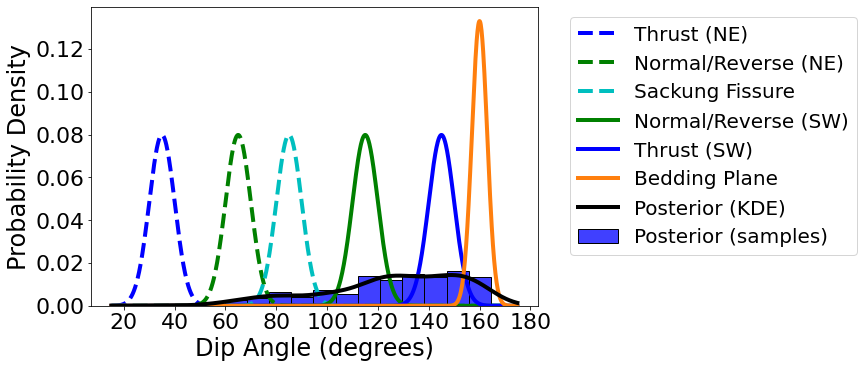

In [21]:
plt.figure(figsize=(8,5.5))
plt.hist(postsamples[0],15,density=True,facecolor=(.25,.25,1),edgecolor='k',label='Posterior (samples)')
for i in range(len(H_labels)):
    plt.plot(xs[0], H_priors[i],styles[i],linewidth=4,label=H_labels[i])
plt.plot(xs[0],post_dip_prob,'-k',linewidth=4,label='Posterior (KDE)')

# plt.yscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dip Angle (degrees)', fontsize=24)
plt.ylabel('Probability Density', fontsize=24)
plt.legend(fontsize=20,loc='upper left', bbox_to_anchor=(1.05,1))

In [22]:
kdex = np.concatenate((xs[0],[xs[0][xs[0].shape[0]-1]]))
kdey = np.concatenate((post_dip_prob/np.max(post_dip_prob),[0]))

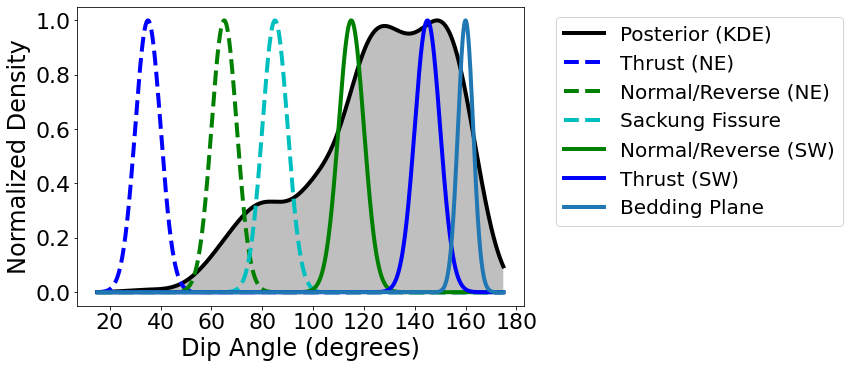

In [23]:

plt.figure(figsize=(8,5.5))
plt.plot(xs[0],post_dip_prob/np.max(post_dip_prob),'-k',linewidth=4,label='Posterior (KDE)')
# plt.fill(xs[0],post_dip_prob/np.max(post_dip_prob),'-k',linewidth=4,facecolor='k',alpha=0.25)
plt.fill(kdex,kdey,'-k',linewidth=4,facecolor='k',alpha=0.25)
# plt.hist(postsamples[0],15,density=True,facecolor=(.25,.25,1),edgecolor='k',label='Posterior (samples)')
for i in range(len(H_labels)):
    plt.plot(xs[0], H_priors[i]/np.max(H_priors[i]),styles[i],linewidth=4,label=H_labels[i])
    

# plt.yscale('log')
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.xlabel('Dip Angle (degrees)', fontsize=24)
plt.ylabel('Normalized Density', fontsize=24)
plt.legend(fontsize=20,loc='upper left', bbox_to_anchor=(1.05,1))



In [24]:
dx = xs[0][1]-xs[0][0]

post_prob = np.zeros(len(H_labels))
for i in range(len(H_labels)):
    post_prob[i] = priors[i] * np.sum(H_priors[i]*post_dip_prob)*dx
    
post_prob = post_prob / np.sum(post_prob)

In [25]:
print("Posterior probability of: ")
for i in range(len(H_labels)):
    print(H_labels[i]+": "+str(np.round(post_prob[i],2)))

Posterior probability of: 
Thrust (NE): 0.0
Normal/Reverse (NE): 0.08
Sackung Fissure: 0.07
Normal/Reverse (SW): 0.29
Thrust (SW): 0.32
Bedding Plane: 0.24


# Export data to csv to experiment with other kinds of sampling

In [29]:
samples_prior_true = inputs[itrain+1:,:]
samples_prior_pred = np.zeros((DNew[itrain+1:,:].shape[0],5))
samples_post_pred = np.zeros((D_N_filt.shape[0],5))
samples_post_pred0 = np.zeros((D_N_filt0.shape[0],5))
samples_post_pred1 = np.zeros((D_N_filt1.shape[0],5))

for i in range(5):
    samples_prior_pred[:,i] = models[i].predict(DNew[itrain+1:,:])
    samples_post_pred[:,i] = models[i].predict(D_N_filt)
    samples_post_pred0[:,i] = models[i].predict(D_N_filt0)
    samples_post_pred1[:,i] = models[i].predict(D_N_filt1)


lbls = [(fullinput.columns[i]+'_true').strip() for i in range(len(fullinput.columns))] + [fullinput.columns[i]+'_pred' for i in range(len(fullinput.columns))]

prior = pd.DataFrame(np.concatenate((samples_prior_true, samples_prior_pred),axis=1), columns=lbls)
measured_pred = pd.DataFrame(samples_post_pred, columns=lbls[5:])
synthetic_pred_2 = pd.DataFrame(samples_post_pred0, columns=lbls[5:])
synthetic_pred_1 = pd.DataFrame(samples_post_pred1, columns=lbls[5:])

measured_post_marginal = pd.DataFrame(np.stack(postsamples,axis=1), columns=lbls[5:])
synthetic_post_marginal_1 = pd.DataFrame(np.stack(postsamples1,axis=1), columns=lbls[5:])
synthetic_post_marginal_2 = pd.DataFrame(np.stack(postsamples0,axis=1), columns=lbls[5:])

prior.to_csv('joint_prior.csv', index=False)
measured_pred.to_csv('measured_data_predictions.csv', index=False)
synthetic_pred_1.to_csv('synthetic_data_predictions_withanomaly.csv', index=False)
synthetic_pred_2.to_csv('synthetic_data_predictions_noanomaly.csv', index=False)
measured_post_marginal.to_csv('measured_marginal_posterior.csv', index=False)
synthetic_post_marginal_1.to_csv('synthetic_marginal_posterior_withanomaly.csv', index=False)
synthetic_post_marginal_2.to_csv('synthetic_marginal_posterior_noanomaly.csv', index=False)


In [ ]:
sample_data(N, srv.values[:,5], srv.values[:,6])-dmean)/dstd